In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pydicom as dicom
import os
import pandas as pd
import numpy as np

In [85]:
hr_data_folder = "../data/HR-pQCT/2207_04650_L"
print(os.getcwd())

# Get every 50th files in the folder
files = [file for file in os.listdir(hr_data_folder) if int(file.split("_")[1].split(".")[0]) % 100 == 0]
files.sort()
print("Total of %d files" % len(files))
print(files)


/home/watten/Documents/Repositories/deep_femur_segmentation/src
Total of 11 files
['FEMUR_00000.DCM', 'FEMUR_00100.DCM', 'FEMUR_00200.DCM', 'FEMUR_00300.DCM', 'FEMUR_00400.DCM', 'FEMUR_00500.DCM', 'FEMUR_00600.DCM', 'FEMUR_00700.DCM', 'FEMUR_00800.DCM', 'FEMUR_00900.DCM', 'FEMUR_01000.DCM']


0.0
0


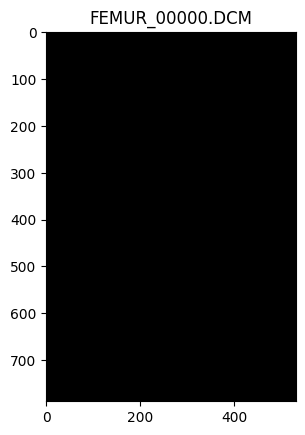

5.179778443570856
127


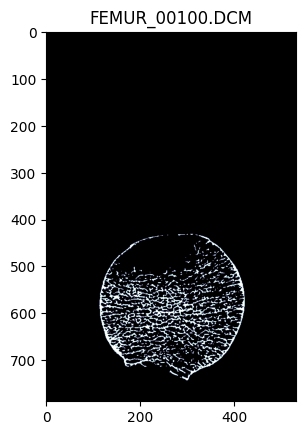

4.965292355253617
127


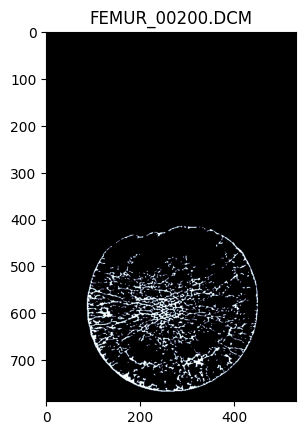

5.691152055265066
127


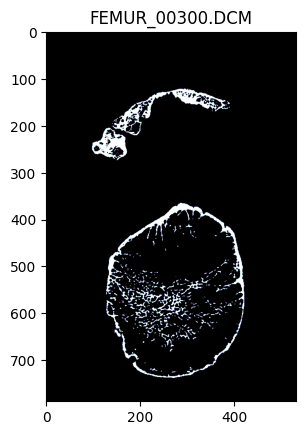

7.81753320483951
0


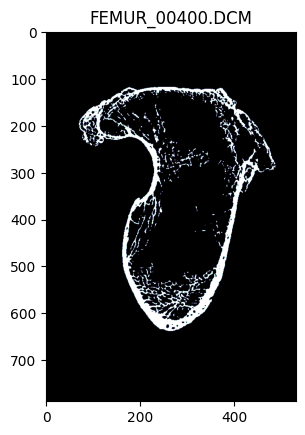

7.423702816686386
127


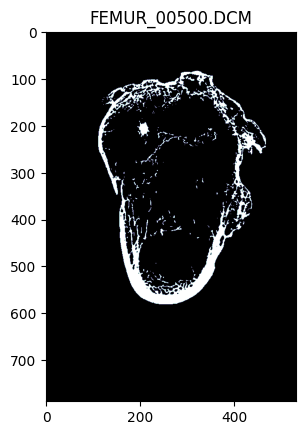

6.76327955039884
127


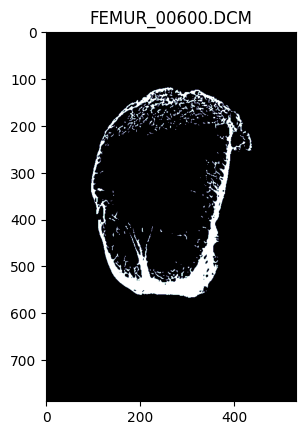

6.9801892103354835
127


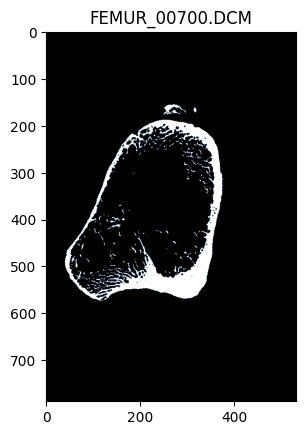

6.847801610625549
127


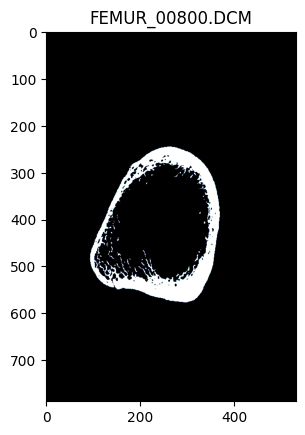

7.3037360215258955
127


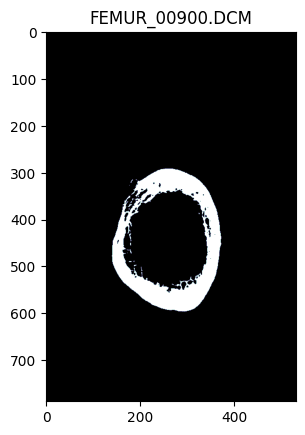

7.949314911644594
0


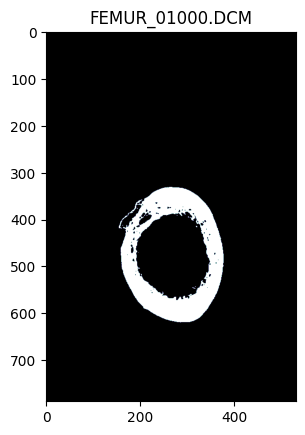

In [89]:
for file in files:
    ds = dicom.dcmread(os.path.join(hr_data_folder, file))
    plt.title(file)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.show()

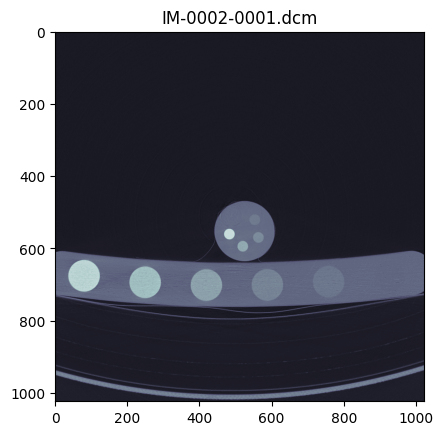

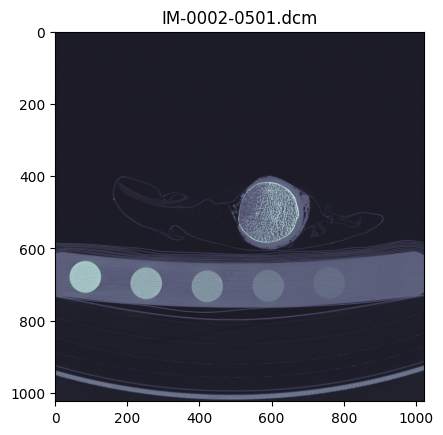

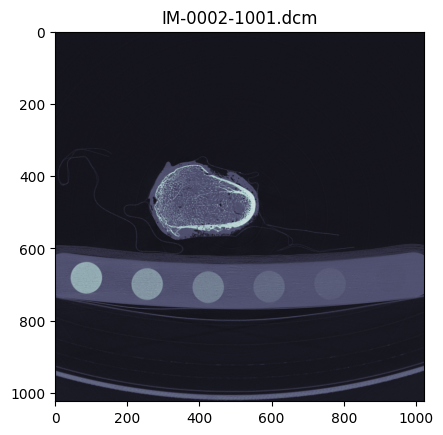

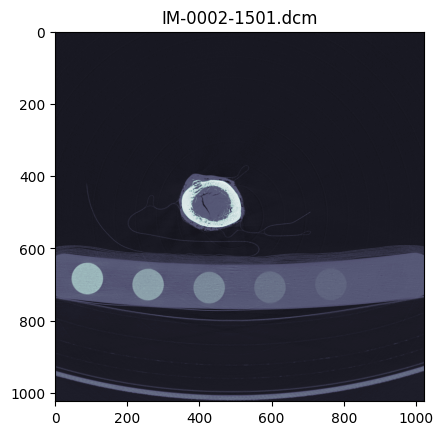

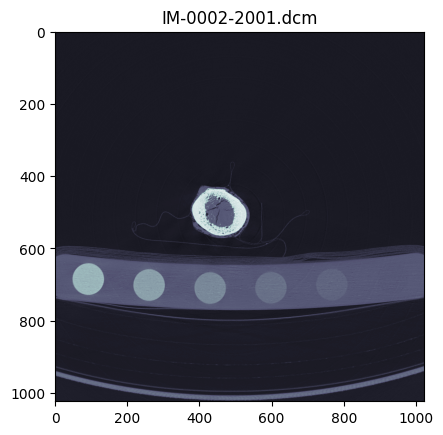

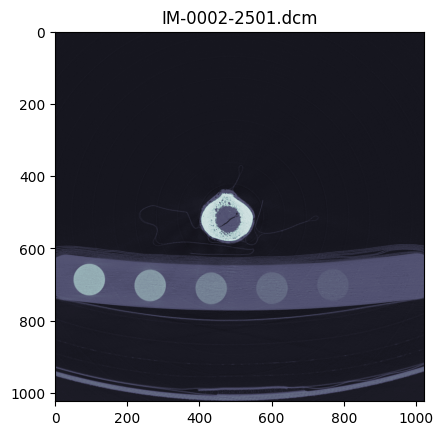

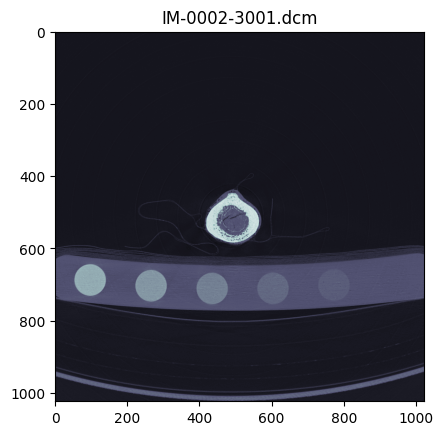

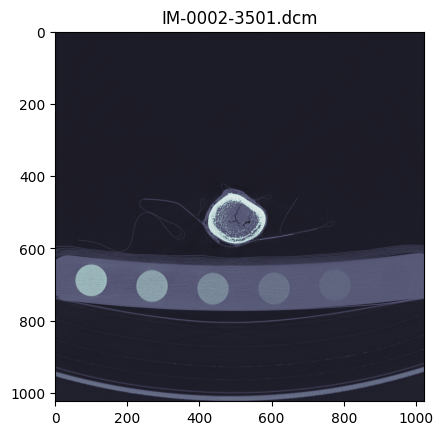

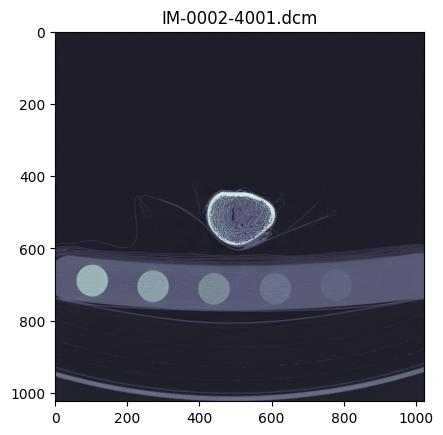

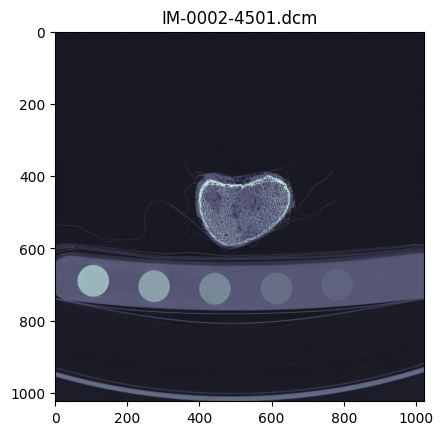

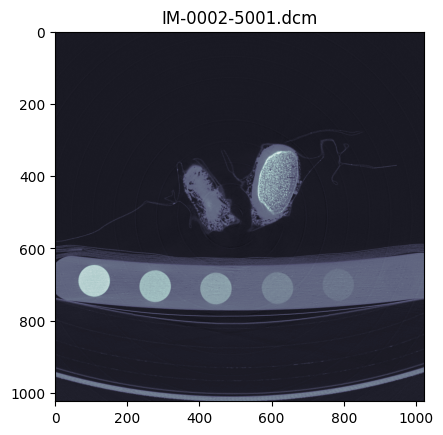

In [2]:
pcct_data_folder = "../data/PCCT/11_2207-04650_L/Ex_vivo_bone_0_20_Br89_Q3_L_4"

files = [file for file in os.listdir(pcct_data_folder) if file.endswith('dcm') and int(file.split("-")[-1].split(".")[0]) % 500 == 1]
files.sort()
for file in files:
    ds = dicom.dcmread(os.path.join(pcct_data_folder, file))
    plt.title(file)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.show()

In [106]:
pcct_data_folder = "../data/PCCT/11_2207-04650_L/Ex_vivo_bone_0_20_Br89_Q3_L_4"

files = [file for file in os.listdir(pcct_data_folder) if file.endswith('dcm') and int(file.split("-")[-1].split(".")[0]) % 500 == 1]
files.sort()
print("Total of %d files" % len(files))
print(files)

Total of 11 files
['IM-0002-0001.dcm', 'IM-0002-0501.dcm', 'IM-0002-1001.dcm', 'IM-0002-1501.dcm', 'IM-0002-2001.dcm', 'IM-0002-2501.dcm', 'IM-0002-3001.dcm', 'IM-0002-3501.dcm', 'IM-0002-4001.dcm', 'IM-0002-4501.dcm', 'IM-0002-5001.dcm']


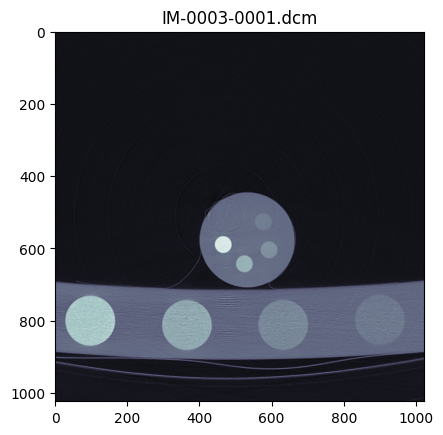

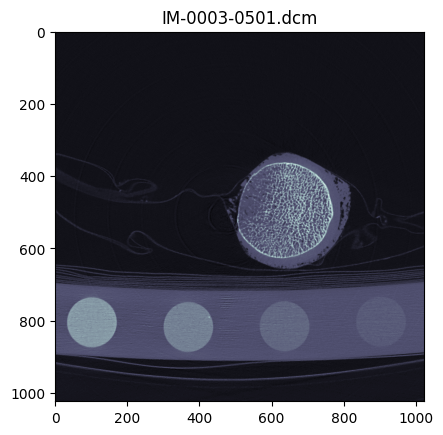

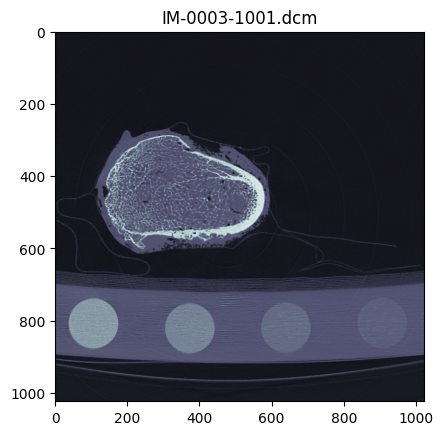

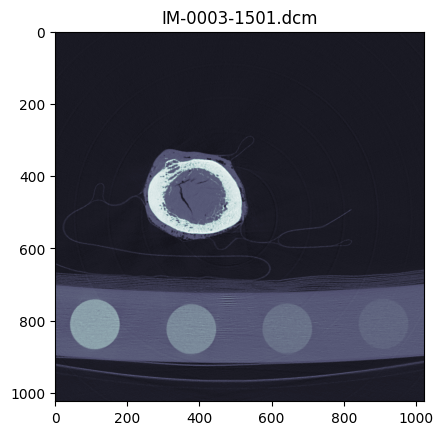

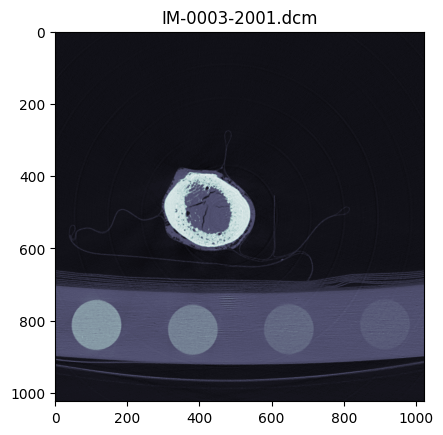

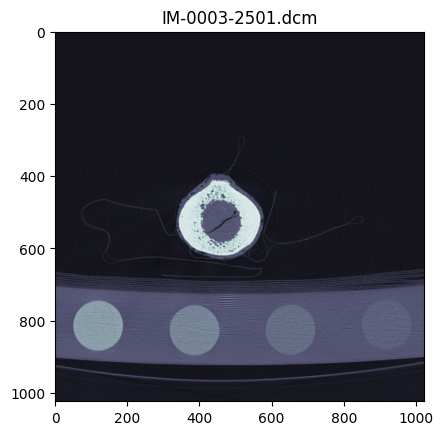

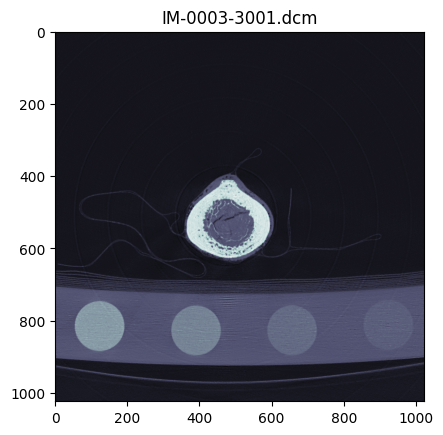

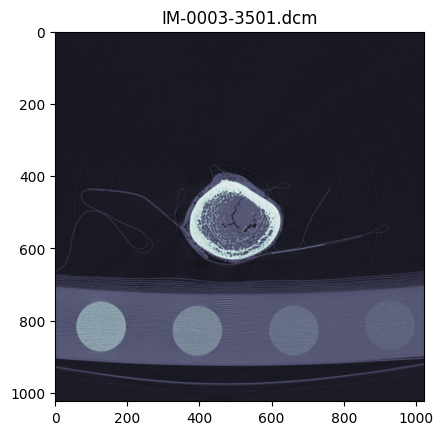

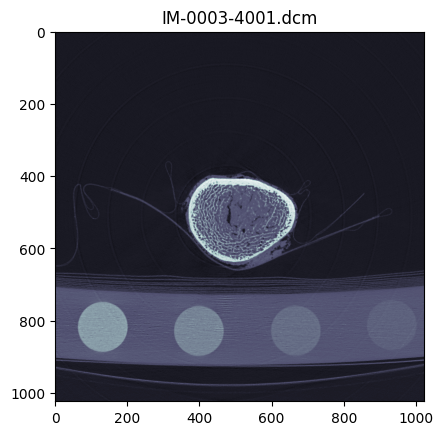

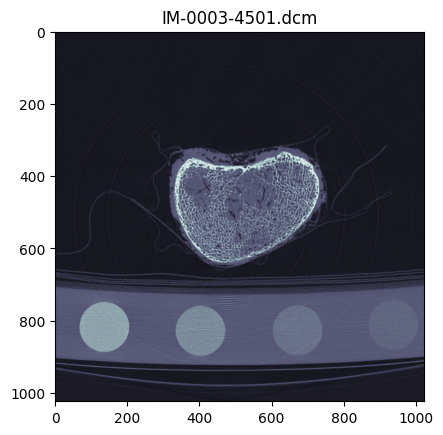

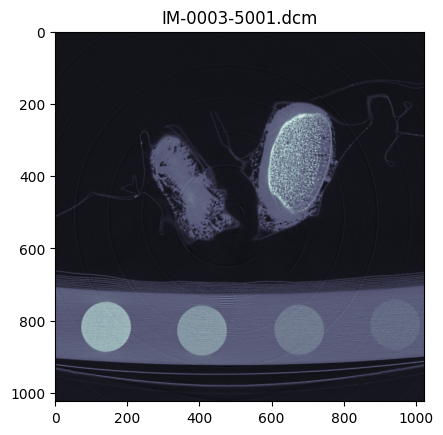

In [99]:
for file in files:
    ds = dicom.dcmread(os.path.join(pcct_data_folder, file))
    plt.title(file)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.show()

In [3]:
from preprocessing.calibration_phantom import get_rod_coordiantes_list
files = [dicom.dcmread(os.path.join(pcct_data_folder, file)).pixel_array for file in os.listdir(pcct_data_folder) if file.endswith('dcm')]

rod_coordinates_list = get_rod_coordiantes_list(files, step_size=1000)
rod_coordinates_list = sorted(rod_coordinates_list, key=lambda x: x[0])

In [105]:
#df = pd.DataFrame(rod_coordinates_list, columns=["x", "y", "radius"])
print(rod_coordinates_list)
#print(df)
#df.to_csv("../data/PCCT/11_2207-04650_L/Ex_vivo_bone_0_20_Br89_Q3_L_4/rod_coordinates.csv", index=False)

[(0, [73, 225, 402, 484, 597, 728], [162, 137, 668, 517, 582, 162], [30, 32, 36, 40, 42, 30]), (1, [389, 796, 826, 894, 942, 1080], [338, 810, 555, 795, 463, 338], [36, 35, 31, 31, 33, 36]), (2, [54, 237, 271, 764, 856, 1056], [317, 827, 357, 852, 564, 317], [32, 31, 30, 31, 30, 32]), (3, [143, 276, 301, 398, 815, 983], [518, 773, 314, 509, 801, 518], [34, 34, 30, 31, 31, 34]), (4, [105, 233, 509, 516, 801, 975], [797, 785, 783, 334, 471, 797], [30, 31, 39, 43, 31, 30]), (5, [99, 105, 303, 373, 706, 857], [81, 540, 286, 271, 375, 81], [38, 36, 30, 32, 30, 38])]


In [108]:
from preprocessing.calibration_phantom import calculate_mean_intensity_list
instensities = calculate_mean_intensity_list(files[::1000], rod_coordinates_list)

coordinates_intensity = [list(x_y_r) + [intensity[1]] for x_y_r, intensity in zip(rod_coordinates_list, instensities)]
print(coordinates_intensity[0])


[0, [95, 264, 433, 601, 770, 938], [688, 704, 712, 711, 702, 688], [44, 43, 43, 43, 43, 44], [9303.443218227127, 9037.13634745461, 8760.822356710572, 8477.9466002136, 8334.327518689925, 8176.717337130652]]


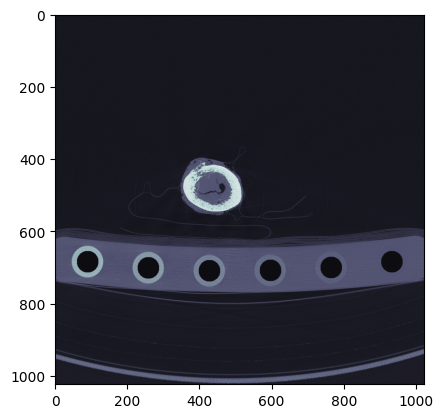

In [7]:
index, all_cx, all_cy, all_radii = rod_coordinates_list[1]
image = files[1].copy()
all_intensities = []

for cx, cy, radius in zip(all_cx, all_cy, all_radii):
    rod_intensities = []

    # Reduce radius to 70% of the original to avoid boundary effects
    radius = int(radius * 0.70)
    radius_squared = radius**2        

    for i in range (cx-radius, cx+radius):
        for j in range (cy-radius, cy+radius):
            # calculate the distance from the center and square it
            dx = i-cx
            dy = j-cy
            distance_squared = dx * dx + dy * dy

            # if the pixel is within the rod circle with reduced radius
            if distance_squared < radius_squared:
                # get its intensity and append it to 
                image[j][i] = 7000
plt.imshow(image, cmap=plt.cm.bone)
plt.show()

In [52]:
from preprocessing.calibrate_image import calibrate_image_list
calibrated_images = calibrate_image_list(files[::1000], coordinates_intensity)



[797.0, 601.2, 399.6, 201.4, 100.8, 0]
[797.0, 601.2, 399.6, 201.4, 100.8, 0]
[797.0, 601.2, 399.6, 201.4, 100.8, 0]
[797.0, 601.2, 399.6, 201.4, 100.8, 0]
[797.0, 601.2, 399.6, 201.4, 100.8, 0]
[797.0, 601.2, 399.6, 201.4, 100.8, 0]


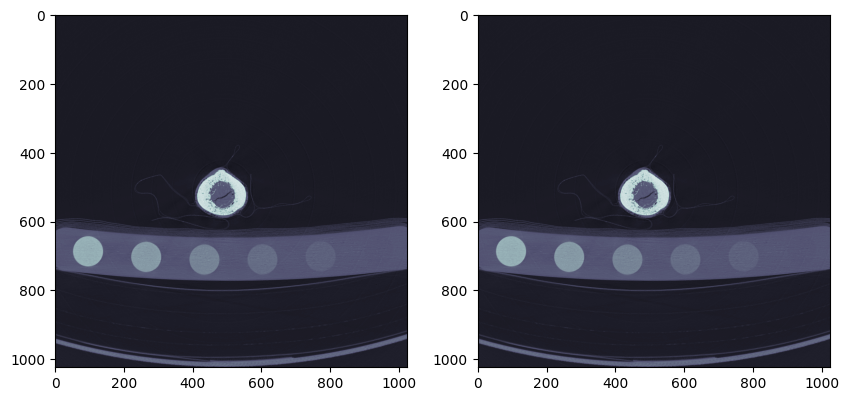

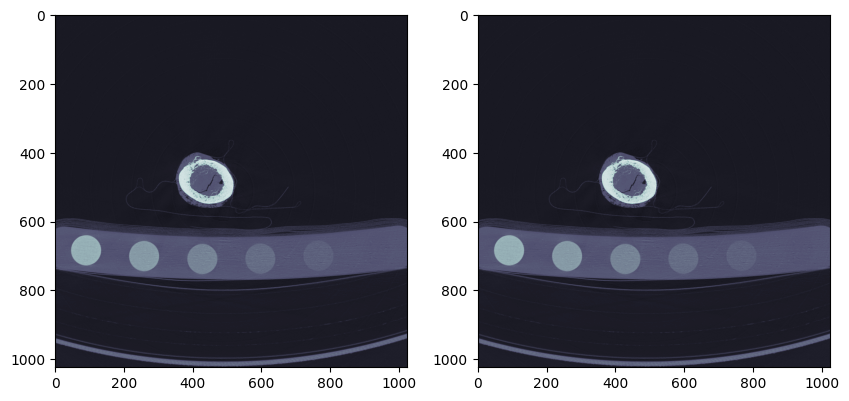

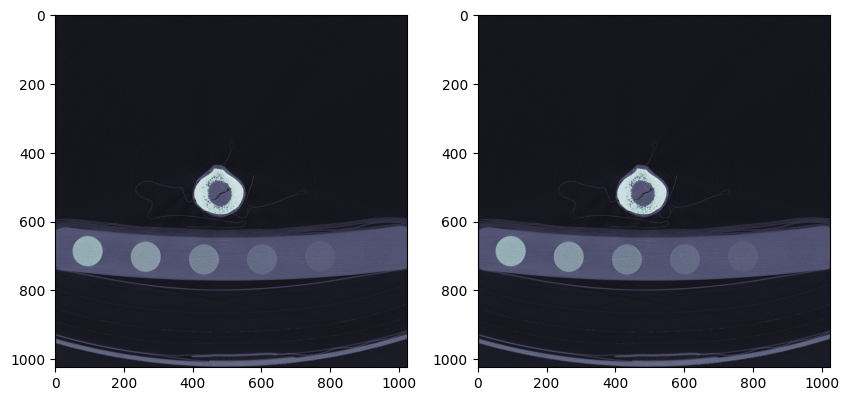

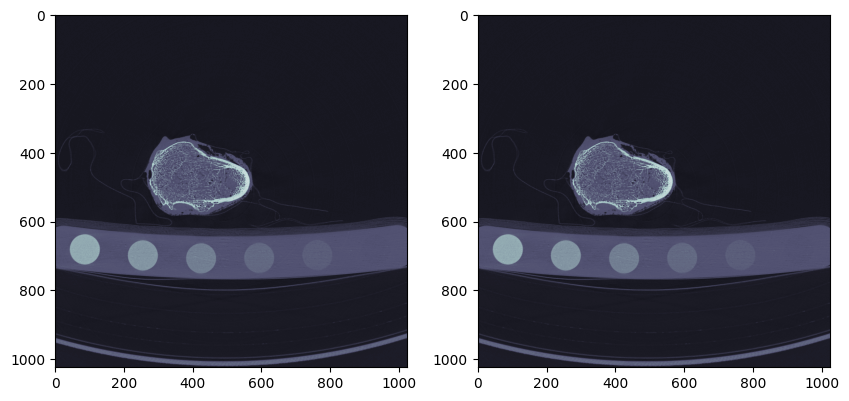

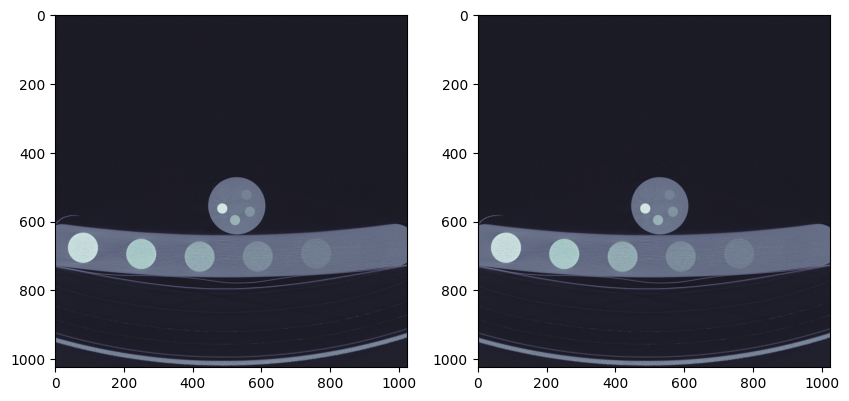

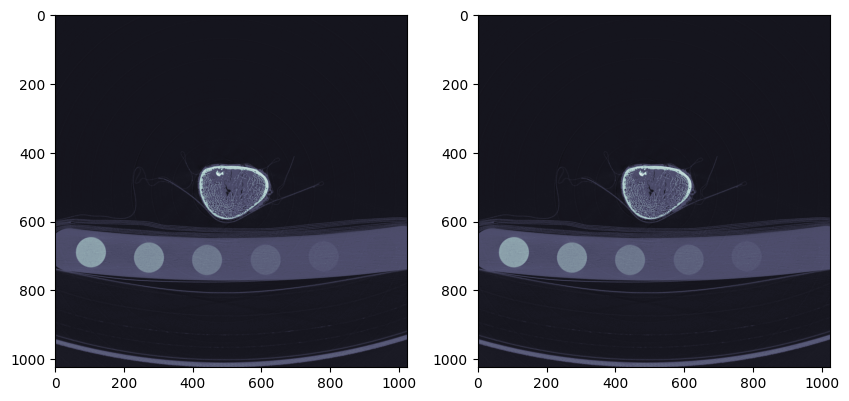

In [110]:
for calibrated, image in zip(calibrated_images, files[::1000]):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(calibrated, cmap=plt.cm.bone)
    axs[1].imshow(image, cmap=plt.cm.bone)
    plt.show()

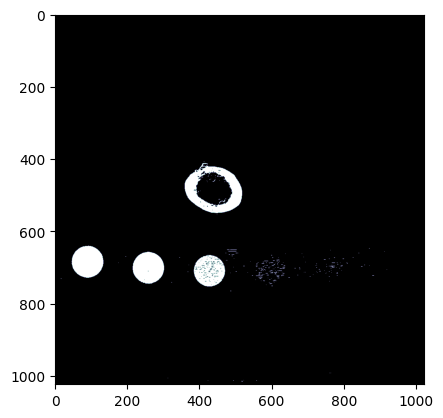

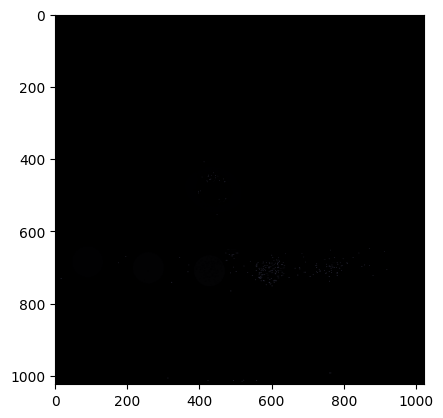

In [70]:
masks = [image > 300 for image in calibrated_images]
plt.imshow(masks[1], cmap=plt.cm.bone)
plt.show()
from preprocessing.calibrate_image import morph_mask_2D
plt.imshow(morph_mask_2D(masks[1]), cmap=plt.cm.bone)
plt.show()